In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [15, 5]

In [14]:
import inspect
import itertools
import re
pd.set_option('max_colwidth', 400)

In [15]:
def linear(x, m1, b1):
    return m1*x + b1

def quadratic(x, a2, b2, c2):
    return (a2 * x * x) + (b2 * x) + c2

def quadraticn(x, a2n, b2n, c2n):
    return (-a2n * x * x) + (b2n * x) + c2n

def cubic(x, a3, b3, c3, d3):
    return (a3 * x * x * x) + (b3 * x * x) + (c3 * x) + d3

def sine(x, A4, f4, C4):
    return A4 * np.sin((2 * np.pi * f4 * x) + C4)

def sinec(x, A4c, f4c, C4c, D4c):
    return A4c * np.sin((2 * np.pi * f4c * x) + C4c) + D4c

def exponential(x, A5, b5):
    return A5 * np.exp(-b5 * x)

def powerlaw(x, A6, alpha6):
    return A6 * (np.power(x, alpha6))

def powerlawn(x, A6m, alpha6n):
    return A6m * (np.power(x, -alpha6n))

def logistic(x, A7, k7, x07):
    return A7/(1 + np.exp(-k7 * (x - x07)))

def gaussian(x, mean, stdev):
    return (1/np.sqrt(2 * np.pi * stdev**2)) * np.exp(-(x - mean)**2 / (2*stdev**2))

def log(x):
    return np.log(x)

In [16]:
def calc_ssr(y, yhat):
    return sum((y - yhat)**2)

names = ['linear', 'quadratic', 'quadraticn', 'cubic', 'sine', 'sinec', 'exponential', 'logistic', 'powerlaw']
fns = [linear, quadratic, quadraticn, cubic,  sine, sinec, exponential, logistic, powerlaw]
fns_dict = dict(zip(names, fns))

names_comb = []
for L in range(0, len(names)+1):
    for subset in itertools.combinations(names, L):    
        names_comb.append(' o '.join(subset))
names_comb = names_comb[1:]
names_comb = [fn for fn in names_comb if len(re.findall('quadratic', fn)) <= 1]
names_comb = [fn for fn in names_comb if len(re.findall('sine', fn)) <= 1]
names_comb = [fn for fn in names_comb if len(re.findall(' o ', fn)) == 1]

for i in range(len(names_comb)):
    text2 = []
    all_args = []
    for fn in names_comb[i].split(' o '):
        args = inspect.getfullargspec(fns_dict[fn]).args[1:]
        all_args.append(args)
        text2.append(f"{fn}(x, {', '.join(args)})")
    text2 = text2[0].replace("(x",  "(" + text2[1])
    text1 = f"def my_{names_comb[i].replace(' o ', '_')}(x, {', '.join(list(itertools.chain(*all_args)))}):"
    exec(f"{text1}\n\treturn {text2}")
    print(f"Successfully created fn: {text1}\n\treturn {text2}")

fns_comb = []
for L in range(0, len(names)+1):
    for subset in itertools.combinations(names, L):    
        fns_comb.append('_'.join(subset))
fns_comb = fns_comb[1:]
fns_comb = ['my_' + fn for fn in fns_comb]
fns_comb = [fn for fn in fns_comb if len(re.findall('quadratic', fn)) <= 1]
fns_comb = [fn for fn in fns_comb if len(re.findall('sine', fn)) <= 1]
fns_comb = [fn for fn in fns_comb if len(re.findall('_', fn)) == 2]
fns_comb = [eval(fn) for fn in fns_comb]

def find_fn(x, y, ind, starting_param = 1):
    name_list = []
    popt_list = []
    ssr_list = []

    fns_comb_dict = dict(zip([names_comb[i] for i in ind], 
                             [fns_comb[i] for i in ind]))
    for name, fn in fns_comb_dict.items():
        n_args = len(inspect.getfullargspec(fn).args) - 1
        p0 = [starting_param]*n_args
        popt, pcov = curve_fit(fn, x, y, p0 = p0)
        yhat = fn(x, *popt) ## calculate yhat

        # Saving output
        name_list.append(name)
        popt_list.append(popt)
        ssr_list.append(calc_ssr(y, yhat))

    params_df = pd.DataFrame({'name': name_list,
                              'parameters': popt_list,
                              'ssr': ssr_list})
    params_df = params_df.sort_values('ssr')
    return params_df

Successfully created fn: def my_linear_quadratic(x, m1, b1, a2, b2, c2):
	return linear(quadratic(x, a2, b2, c2), m1, b1)
Successfully created fn: def my_linear_quadraticn(x, m1, b1, a2n, b2n, c2n):
	return linear(quadraticn(x, a2n, b2n, c2n), m1, b1)
Successfully created fn: def my_linear_cubic(x, m1, b1, a3, b3, c3, d3):
	return linear(cubic(x, a3, b3, c3, d3), m1, b1)
Successfully created fn: def my_linear_sine(x, m1, b1, A4, f4, C4):
	return linear(sine(x, A4, f4, C4), m1, b1)
Successfully created fn: def my_linear_sinec(x, m1, b1, A4c, f4c, C4c, D4c):
	return linear(sinec(x, A4c, f4c, C4c, D4c), m1, b1)
Successfully created fn: def my_linear_exponential(x, m1, b1, A5, b5):
	return linear(exponential(x, A5, b5), m1, b1)
Successfully created fn: def my_linear_logistic(x, m1, b1, A7, k7, x07):
	return linear(logistic(x, A7, k7, x07), m1, b1)
Successfully created fn: def my_linear_powerlaw(x, m1, b1, A6, alpha6):
	return linear(powerlaw(x, A6, alpha6), m1, b1)
Successfully created fn:

In [17]:
df3 = pd.read_csv('~/Desktop/fit_data3.csv')

In [18]:
x3 = df3.x.to_numpy()
y3 = df3.y.to_numpy()

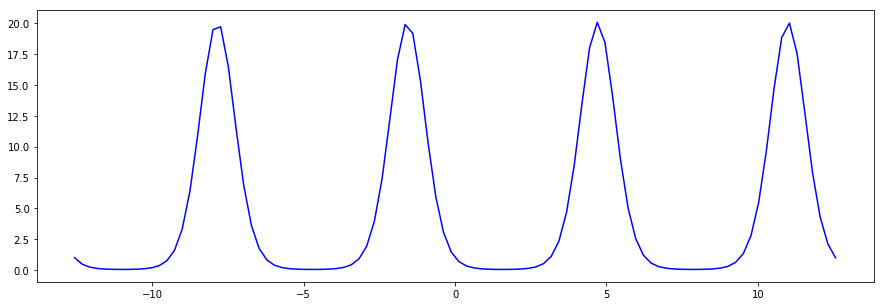

In [19]:
plt.plot(x3, y3, 'b-')

In [20]:
ind = list(range(0,7)) +\
list(range(8,13)) +\
list(range(15,19)) +\
list(range(20,24)) +\
list(range(25,27)) +\
list(range(28,30)) +\
list(range(31,32)) +\
list(range(33,33))

params_df = find_fn(x3, y3, ind = ind)
params_df.assign(parameters = [np.around(l,2) for l in params_df.parameters])

C:\Users\pdonato\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,name,parameters,ssr
23,sinec o logistic,"[6.3, 1.29, -0.0, 3.06, 1.13, 0.61, 1.38]",3566.828859
2,linear o cubic,"[1.69, -947.0, 0.0, -0.0, -0.16, 562.92]",4050.417654
7,quadratic o cubic,"[0.31, -204.41, 31025.71, -0.0, 0.0, 0.0, 238.44]",4050.453515
10,quadratic o exponential,"[0.0, -0.0, 5.43, 0.11, 0.89]",4084.015099
18,cubic o exponential,"[-0.01, 64.67, 42.4, 5.4, -0.0, 0.99]",4086.539004
5,linear o exponential,"[1.18, 5.39, -0.01, 0.56]",4129.004244
14,quadraticn o exponential,"[0.01, -66.59, 5.2, 0.0, 1.01]",4163.799150
1,linear o quadraticn,"[1.25, -185.95, 0.0, 0.11, 153.15]",4214.150645
0,linear o quadratic,"[1.47, -64.56, -0.0, 0.09, 47.27]",4214.150648
22,sinec o exponential,"[0.31, 734.14, 0.97, 5.0, -732.14, 1.0]",4308.658159


In [21]:
names = ['linear', 'quadratic', 'quadraticn', 'cubic', 'sine', 'sinec', 'exponential', 'logistic', 'powerlaw']
fns = [linear, quadratic, quadraticn, cubic,  sine, sinec, exponential, logistic, powerlaw]
fns_dict = dict(zip(names, fns))

names_comb = []
for L in range(0, len(names)+1):
    for subset in itertools.combinations(names, L):    
        names_comb.append(' o '.join(subset))
names_comb = names_comb[1:]
names_comb = [fn for fn in names_comb if len(re.findall('quadratic', fn)) <= 1]
names_comb = [fn for fn in names_comb if len(re.findall('sine', fn)) <= 1]
names_comb = [fn for fn in names_comb if len(re.findall(' o ', fn)) == 1]

for i in range(len(names_comb)):
    text2 = []
    all_args = []
    for fn in names_comb[i].split(' o '):
        args = inspect.getfullargspec(fns_dict[fn]).args[1:]
        all_args.append(args)
        text2.append(f"{fn}(x, {', '.join(args)})")
    text2 = text2[1].replace("(x",  "(" + text2[0])
    text1 = f"def my_{names_comb[i].replace(' o ', '_')}(x, {', '.join(list(itertools.chain(*all_args)))}):"
    exec(f"{text1}\n\treturn {text2}")
    print(f"Successfully created fn: {text1}\n\treturn {text2}")

fns_comb = []
for L in range(0, len(names)+1):
    for subset in itertools.combinations(names, L):    
        fns_comb.append('_'.join(subset))
fns_comb = fns_comb[1:]
fns_comb = ['my_' + fn for fn in fns_comb]
fns_comb = [fn for fn in fns_comb if len(re.findall('quadratic', fn)) <= 1]
fns_comb = [fn for fn in fns_comb if len(re.findall('sine', fn)) <= 1]
fns_comb = [fn for fn in fns_comb if len(re.findall('_', fn)) == 2]
fns_comb = [eval(fn) for fn in fns_comb]

def find_fn_switch(x, y, ind, starting_param = 1):
    name_list = []
    popt_list = []
    ssr_list = []

    fns_comb_dict = dict(zip([names_comb[i] for i in ind], 
                             [fns_comb[i] for i in ind]))
    for name, fn in fns_comb_dict.items():
        n_args = len(inspect.getfullargspec(fn).args) - 1
        p0 = [starting_param]*n_args
        popt, pcov = curve_fit(fn, x, y, p0 = p0)
        yhat = fn(x, *popt) ## calculate yhat

        # Saving output
        name_list.append(name)
        popt_list.append(popt)
        ssr_list.append(calc_ssr(y, yhat))

    params_df = pd.DataFrame({'name': name_list,
                              'parameters': popt_list,
                              'ssr': ssr_list})
    params_df = params_df.sort_values('ssr')
    return params_df

Successfully created fn: def my_linear_quadratic(x, m1, b1, a2, b2, c2):
	return quadratic(linear(x, m1, b1), a2, b2, c2)
Successfully created fn: def my_linear_quadraticn(x, m1, b1, a2n, b2n, c2n):
	return quadraticn(linear(x, m1, b1), a2n, b2n, c2n)
Successfully created fn: def my_linear_cubic(x, m1, b1, a3, b3, c3, d3):
	return cubic(linear(x, m1, b1), a3, b3, c3, d3)
Successfully created fn: def my_linear_sine(x, m1, b1, A4, f4, C4):
	return sine(linear(x, m1, b1), A4, f4, C4)
Successfully created fn: def my_linear_sinec(x, m1, b1, A4c, f4c, C4c, D4c):
	return sinec(linear(x, m1, b1), A4c, f4c, C4c, D4c)
Successfully created fn: def my_linear_exponential(x, m1, b1, A5, b5):
	return exponential(linear(x, m1, b1), A5, b5)
Successfully created fn: def my_linear_logistic(x, m1, b1, A7, k7, x07):
	return logistic(linear(x, m1, b1), A7, k7, x07)
Successfully created fn: def my_linear_powerlaw(x, m1, b1, A6, alpha6):
	return powerlaw(linear(x, m1, b1), A6, alpha6)
Successfully created fn:

In [22]:
ind = list(range(1,7)) +\
list(range(9,13)) +\
list(range(14,19)) +\
list(range(20,22)) +\
list(range(23,24)) +\
list(range(25,27)) +\
list(range(28,29)) +\
list(range(30,32)) +\
list(range(33,33))

params_df = find_fn_switch(x3, y3, ind = ind)
params_df.assign(parameters = [np.around(l,2) for l in params_df.parameters])

C:\Users\pdonato\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power


,name,parameters,ssr
7,quadratic o sinec,"[100.94, 100.92, 322.33, -2.49, -98.93, -1707.2, 4.89]",3948.838806
9,quadratic o logistic,"[10.9, -34.21, 12.58, 5.65, 0.2, 24.25]",3967.445382
16,cubic o sinec,"[2.06, 2.01, 3.99, 37505.91, -2.62, -0.19, -234031.63, 4.51]",4011.676207
1,linear o cubic,"[0.72, -2.22, 0.01, 0.07, -0.23, 4.26]",4050.417654
12,quadraticn o sinec,"[85.44, 85.46, -3581.5, -2.14, -83.44, 23085.5, 4.85]",4090.280215
10,quadraticn o cubic,"[-0.05, 0.41, -38.72, -0.01, -0.6, -17.12, -148.91]",4145.560225
0,linear o quadraticn,"[0.04, 4.81, 1.85, 21.34, -54.78]",4214.150645
8,quadratic o exponential,"[0.0, 5.06, -9.46, 4.99, -0.01]",4217.574767
3,linear o sinec,"[-13.46, 738.41, 0.21, 15.46, -4722.93, 4.84]",4310.625001
18,sine o exponential,"[-0.14, 0.96, 1.49, 4.84, -0.23]",4311.600915
